In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
from jax import random
import jax
from numpyro.infer import MCMC, NUTS, Predictive
from scipy.spatial.distance import cdist
import time
import seaborn as sns
import pickle
import os

jax.config.update("jax_enable_x64", True)
print(numpyro.__version__)

0.16.1


In [2]:
# os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=2"

In [2]:
print(jax.local_device_count())

1


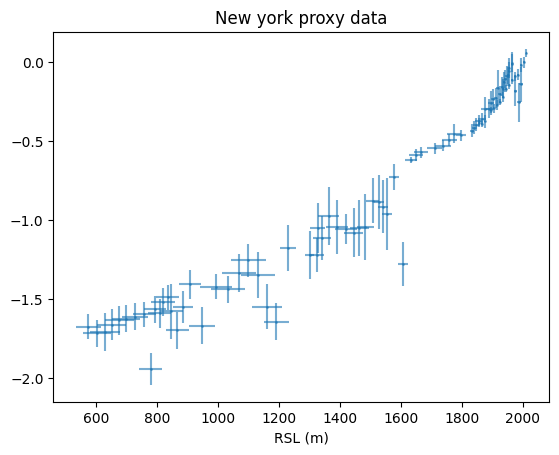

In [3]:
df = pd.read_csv("./NYC.csv")
plt.errorbar(
    df["Age"],
    df["RSL"],
    xerr=df["AgeError"],
    yerr=df["RSLError"],
    fmt="o",
    markersize=1,
    alpha=0.6,
)
plt.title("New york proxy data")
plt.xlabel("Age (CE)")
plt.xlabel("RSL (m)")
plt.show()

No GIA correction


In [4]:
# import jax.scipy.spatial


# interval = 30  # years
# kappa = 1.99
# L = 30  # number of grid points

# x = jnp.array(df["Age"] / 1000)
# y = jnp.array(df["RSL"])
# var_x = jnp.array(df["AgeError"] / 1000) ** 2
# var_y = jnp.array(df["RSLError"]) ** 2


# def make_cov_matrix(vx, vy):
#     return jnp.array([[vx, 0.0], [0.0, vy]])


# V = jax.vmap(make_cov_matrix)(var_x, var_y)

# # for numerical integration
# x_max = max(x + jnp.sqrt(var_x))
# x_min = min(x - jnp.sqrt(var_x))
# x_grid = jnp.r_[x_min, jnp.arange(min(x), max(x), interval / 1000), x_max]
# x_star = x_grid - min(x)
# Ngrid = len(x_star)
# Dist = jnp.array(cdist(x_star[:, None], x_star[:, None], metric="euclidean"))
# D = np.c_[x - min(x), y]
# index = jnp.arange(1, L + 1)
# cosfunc = jnp.cos((jnp.pi * (2 * index - 1)) / (2 * L))


# quad1 = np.zeros((len(df), Ngrid, L))
# quad2 = np.ones((len(df), Ngrid, L))

# for j in range(Ngrid):
#     for k in range(len(df)):
#         quad1[k, j, :] = np.abs((x[k] * cosfunc / 2) + (x[k] / 2) - x_star[j]) ** kappa
#         quad2[k, j, :] = (x[k] / 2) * (np.pi / L) * (np.sqrt(1 - cosfunc**2))

# quad1 = jnp.array(quad1)
# quad2 = jnp.array(quad2)

In [5]:
# We're not accounting for GIA to begin with
year_of_correction = 2010
convert_bp_to_ce = False
interval = 30  # years
kappa = 1.99


# preprocessing

df["x"] = (1950 - df["Age"]) if convert_bp_to_ce else df["Age"]
df["y"] = df["RSL"]
df["var_x"] = (df["AgeError"] / 1000) ** 2  # x in thousands of years
df["var_y"] = df["RSLError"] ** 2
# variance and precision matrices
V = np.empty((2, 2, len(df)))
P = np.empty((2, 2, len(df)))
for i in range(len(df)):
    V[:, :, i] = np.array(
        [
            [df["var_x"].iloc[i], 0.0],
            [0.0, df["var_y"].iloc[i]],
        ]
    )
    P[:, :, i] = np.linalg.inv(V[:, :, i])

# include error bounds by default
x_max = (df["x"] + df["AgeError"]).max() / 1000
x_min = (df["x"] - df["AgeError"]).min() / 1000
x_grid = np.concatenate(
    [
        [x_min],  # scalar
        np.arange(min(df["x"] / 1000), max(df["x"] / 1000), interval / 1000),
        [x_max],  # scalar
    ]
)
x = (df["x"] / 1000) - min(df["x"] / 1000)
x_star = x_grid - min(df["x"] / 1000)
Ngrid = len(x_star)
# add axis to x_star
Dist = cdist(x_star[:, None], x_star[:, None], metric="euclidean")
D = np.c_[x, df["y"]]

## quadrature init
L = 30
index = np.arange(1, L + 1)
# cosfunc = np.cos(np.pi * (index + 0.5) / L)
cosfunc = np.cos((np.pi * (2 * index - 1)) / (2 * L))
# plt.scatter(range(len(cosfunc)), cosfunc)
quad1 = np.zeros((len(df), Ngrid, L))
quad2 = np.ones((len(df), Ngrid, L))

for j in range(Ngrid):
    for k in range(len(df)):
        quad1[k, j, :] = np.abs((x[k] * cosfunc / 2) + (x[k] / 2) - x_star[j]) ** kappa
        quad2[k, j, :] = (x[k] / 2) * (np.pi / L) * (np.sqrt(1 - cosfunc**2))

V = V.transpose(2, 0, 1)
V = jnp.array(V)
D = jnp.array(D)
Dist = jnp.array(Dist)
quad1 = jnp.array(quad1)
quad2 = jnp.array(quad2)

In [6]:
def eiv_igp(D=D, V=V, m=Ngrid, Dist=Dist, kappa=kappa, quad1=quad1, quad2=quad2):
    N = len(V)
    x_true = numpyro.sample("x_true", dist.Normal(0, np.sqrt(1e3)).expand([N]))
    beta0 = numpyro.sample("beta0", dist.Normal(0, 1))
    # sigma.y in the jags code
    sigma = numpyro.sample("sigma", dist.Uniform(0.01, 1))
    p = numpyro.sample("p", dist.Uniform(0, 1))
    tau_g = numpyro.sample("tau_g", dist.Gamma(10.0, 100.0))
    # just to keep track, will be used later
    sigma_g = numpyro.deterministic("sigma_g", jnp.pow(tau_g, -0.5))

    # Construct the GP kernel
    K = jnp.zeros((m, m))
    K = K.at[jnp.diag_indices(m)].set(1 + 1e-5)
    i, j = jnp.triu_indices(m, k=1)
    triu_values = p ** ((Dist[i, j]) ** kappa)
    K = K.at[i, j].set(triu_values)
    K = K.at[j, i].set(triu_values)  # mirror to lower triangle
    K = numpyro.deterministic("K", K / tau_g)
    w_m = numpyro.sample(
        "w_m",
        dist.MultivariateNormal(jnp.zeros(m), K),
    )

    K_gw = jnp.sum(p**quad1 * quad2, axis=2)
    K_w_inv = numpyro.deterministic("K_w_inv", jnp.linalg.inv(K))
    w_tilde_m = jnp.matmul(K_gw, jnp.matmul(K_w_inv, w_m))

    mu = jnp.c_[
        x_true,
        beta0 + w_tilde_m,
    ]
    mu = numpyro.deterministic("mu", mu)
    V_new = V.at[:, 1, 1].set(V[:, 1, 1] + sigma**2)

    with numpyro.plate("observations", N):
        numpyro.sample(
            "z",
            dist.MultivariateNormal(
                mu,
                V_new,
            ),
            obs=D,
        )


In [7]:
rng_key = random.PRNGKey(0)

dict_keys(['K', 'K_w_inv', 'beta0', 'mu', 'p', 'sigma', 'sigma_g', 'tau_g', 'w_m', 'x_true', 'z'])


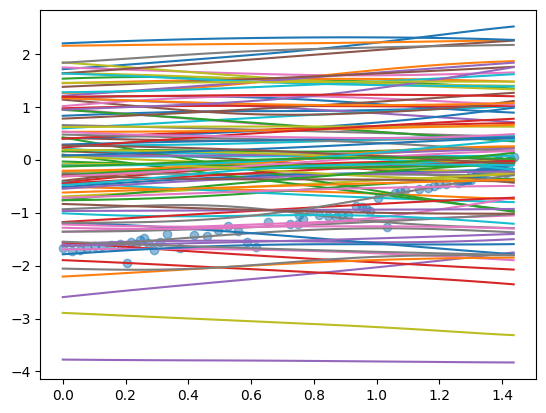

In [8]:
rng_key, rng_key_ = random.split(rng_key)
pp = Predictive(eiv_igp, num_samples=100)
prior_predictive = pp(rng_key_)
print(prior_predictive.keys())
plt.scatter(D[:, 0], D[:, 1], alpha=0.5)
# print(prior_predictive["mu"].shape)
mu = prior_predictive["mu"][:, :, 1]
s_idx = jnp.argsort(D[:, 0])
for i in range(len(mu)):
    plt.plot(D[:, 0][s_idx], mu[i][s_idx])

In [9]:
numpyro.set_host_device_count(2)
rng_key, rng_key_ = random.split(rng_key)

k = NUTS(
    eiv_igp,
    init_strategy=numpyro.infer.init_to_median,
)

mcmc = MCMC(
    k,
    num_warmup=5_000,
    num_samples=20_000,
    thinning=10,
    # num_chains=2,
    # chain_method="parallel",
)
mcmc.run(rng_key_)
mcmc.print_summary()

# posterior = mcmc.get_samples()


with open("mcmc_results.pkl", "wb") as f:
    pickle.dump(mcmc, f)

sample: 100%|██████████| 25000/25000 [6:20:31<00:00,  1.09it/s, 1023 steps of size 4.37e-03. acc. prob=0.82]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -1.70      0.04     -1.70     -1.76     -1.63   1598.38      1.00
         p      0.43      0.16      0.44      0.16      0.71   1650.74      1.00
     sigma      0.05      0.01      0.05      0.03      0.06   1942.98      1.00
     tau_g      0.18      0.04      0.18      0.12      0.24    534.68      1.00
    w_m[0]      1.64      1.12      1.59     -0.29      3.36   1001.42      1.00
    w_m[1]      1.82      1.06      1.77      0.01      3.48    920.28      1.00
    w_m[2]      1.97      1.02      1.90      0.13      3.50    862.62      1.00
    w_m[3]      2.12      0.98      2.06      0.38      3.63    806.76      1.00
    w_m[4]      2.27      0.95      2.21      0.62      3.76    751.61      1.00
    w_m[5]      2.44      0.92      2.39      0.83      3.83    699.58      1.00
    w_m[6]      2.61      0.90      2.55      1.05      3.98    652.43      1.00
    w_m[7]      2.78      0

In [73]:
# import pickle

# with open("mcmc_results.pkl", "wb") as f:
#     pickle.dump(mcmc, f)


In [74]:
# with open("mcmc_results.pkl", "rb") as f:
#     mcmc: MCMC = pickle.load(f)

# posterior = mcmc.get_samples()
# mcmc.print_summary()
# print(posterior.keys())



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     beta0     -0.73      0.05     -0.73     -0.78     -0.67     18.19      0.71
         p      0.55      0.01      0.54      0.53      0.57      8.81      1.26
     sigma      0.58      0.02      0.59      0.56      0.60      9.81      0.78
     tau_g      0.12      0.03      0.10      0.08      0.17      3.50      1.66
    w_m[0]     -0.34      0.12     -0.29     -0.49     -0.21      2.86      3.58
    w_m[1]     -0.25      0.10     -0.20     -0.38     -0.15      2.92      4.36
    w_m[2]     -0.21      0.11     -0.15     -0.34     -0.11      2.91      4.96
    w_m[3]     -0.14      0.09     -0.13     -0.25     -0.04      2.60      4.98
    w_m[4]     -0.08      0.09     -0.07     -0.21      0.01      2.84      2.71
    w_m[5]      0.01      0.07      0.01     -0.10      0.07      2.83      2.67
    w_m[6]      0.06      0.06      0.06     -0.01      0.13      3.86      2.18
    w_m[7]      0.13      0

In [10]:
posterior = mcmc.get_samples()

<Axes: ylabel='Density'>

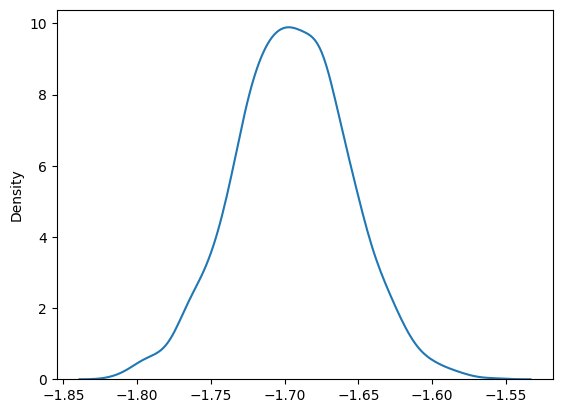

In [11]:
sns.kdeplot(posterior["beta0"])

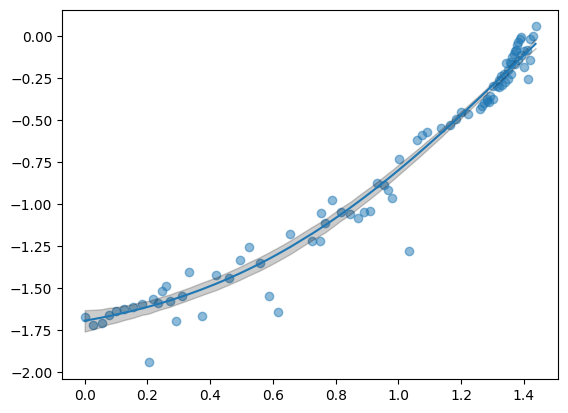

In [12]:
plt.scatter(D[:, 0], D[:, 1], alpha=0.5)
mu = posterior["mu"][:, :, 1]
s_idx = jnp.argsort(D[:, 0])

plt.plot(D[:, 0][s_idx], mu.mean(axis=0)[s_idx])

hpdi = numpyro.diagnostics.hpdi(mu, prob=0.9, axis=0)
plt.fill_between(x, hpdi[0], hpdi[1], alpha=0.2, color="black")

In [13]:
rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(eiv_igp, posterior)(rng_key_, D=None)

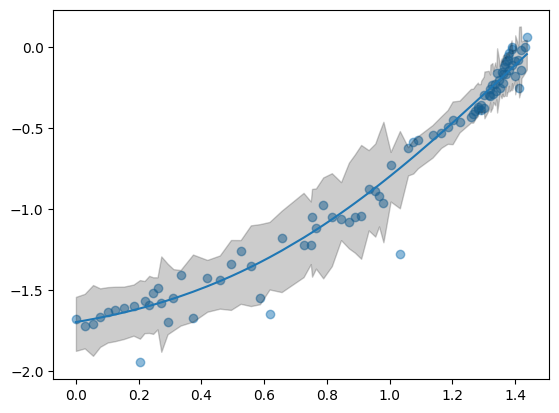

In [14]:
plt.scatter(D[:, 0], D[:, 1], alpha=0.5)
yhat = predictive["z"][:, :, 1]
plt.plot(D[:, 0][s_idx], mu.mean(axis=0)[s_idx])
hpdi = numpyro.diagnostics.hpdi(yhat, prob=0.9, axis=0)
plt.fill_between(
    D[:, 0][s_idx], hpdi[0][s_idx], hpdi[1][s_idx], alpha=0.2, color="black"
)
# print(yhat.shape)
# for i in range(100):
#     plt.plot(D[:, 0][s_idx], yhat[i][s_idx], c="b", alpha=0.1)

In [41]:
quad1.shape

(91, 50, 30)

In [33]:
# n_iter = posterior["beta0"].shape[0]
# Kgw = np.zeros((n_iter, Ngrid, Ngrid))
# K = np.zeros((n_iter, Ngrid, Ngrid))
# Kwinv = np.zeros((n_iter, Ngrid, Ngrid))


quad1n = np.zeros((Ngrid, Ngrid, L))
quad2n = np.ones((Ngrid, Ngrid, L))
for j in range(Ngrid):
    for k in range(Ngrid):
        quad1n[k, j, :] = np.abs((x[k] * cosfunc / 2) + (x[k] / 2) - x_star[j]) ** kappa
        quad2n[k, j, :] = (x[k] / 2) * (np.pi / L) * (np.sqrt(1 - cosfunc**2))


# for i in range(n_iter):
#     for j in range(Ngrid):
#         for k in range(Ngrid):
#             Kgw[i, j, k] = np.sum(posterior["p"][i] ** quad1[j, k, :] * quad2[j, k, :])

# broadcasting+vmap is badass
Kgw = np.sum(
    posterior["p"][:, None, None, None] ** quad1n[None, :, :, :]
    * quad2n[None, :, :, :],
    axis=-1,
)
K = posterior["p"][:, None, None] ** (Dist[None, :, :] * kappa)

Kwinv = jax.vmap(jnp.linalg.inv)(K)

# Get predictions using jax operations
pred = posterior["beta0"][:, None] + jnp.einsum(
    "ijk,ikl,il->ij", Kgw, Kwinv, posterior["w_m"]
)


In [31]:
# Convert predictions to long format DataFrame
pred_df = pd.DataFrame(pred, columns=x_star)
pred_long = pd.melt(
    pred_df, value_vars=pred_df.columns, var_name="year", value_name="value"
)
pred_long["year"] = pred_long["year"].astype(float)

# sl estimates

# Group by year and calculate summary statistics
sl_estimates = (
    pred_long.groupby("year")
    .agg(
        {
            "value": [
                "mean",
                lambda x: np.mean(x) - 2 * np.std(x),
                lambda x: np.mean(x) + 2 * np.std(x),
            ]
        }
    )
    .reset_index()
)

# Rename columns
sl_estimates.columns = ["year", "SL_est", "SL_lwr", "SL_upr"]


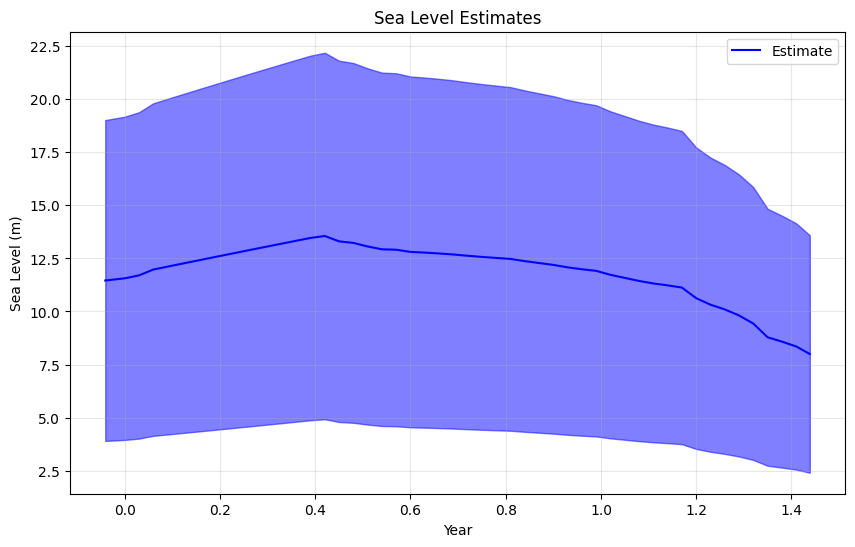

In [32]:
# Plot SL estimates
plt.figure(figsize=(10, 6))
plt.plot(sl_estimates["year"], sl_estimates["SL_est"], "b-", label="Estimate")
plt.fill_between(
    sl_estimates["year"],
    sl_estimates["SL_lwr"],
    sl_estimates["SL_upr"],
    color="b",
    alpha=0.5,
)


plt.xlabel("Year")
plt.ylabel("Sea Level (m)")
plt.title("Sea Level Estimates")
plt.legend()
plt.grid(True, alpha=0.3)


In [16]:
dydt = posterior["w_m"]
mean_dydt = jnp.mean(dydt, axis=1)
sd_rate = np.std(mean_dydt)
u95 = np.quantile(mean_dydt, 0.975)
l95 = np.quantile(mean_dydt, 0.025)

# mean_dydt.shape


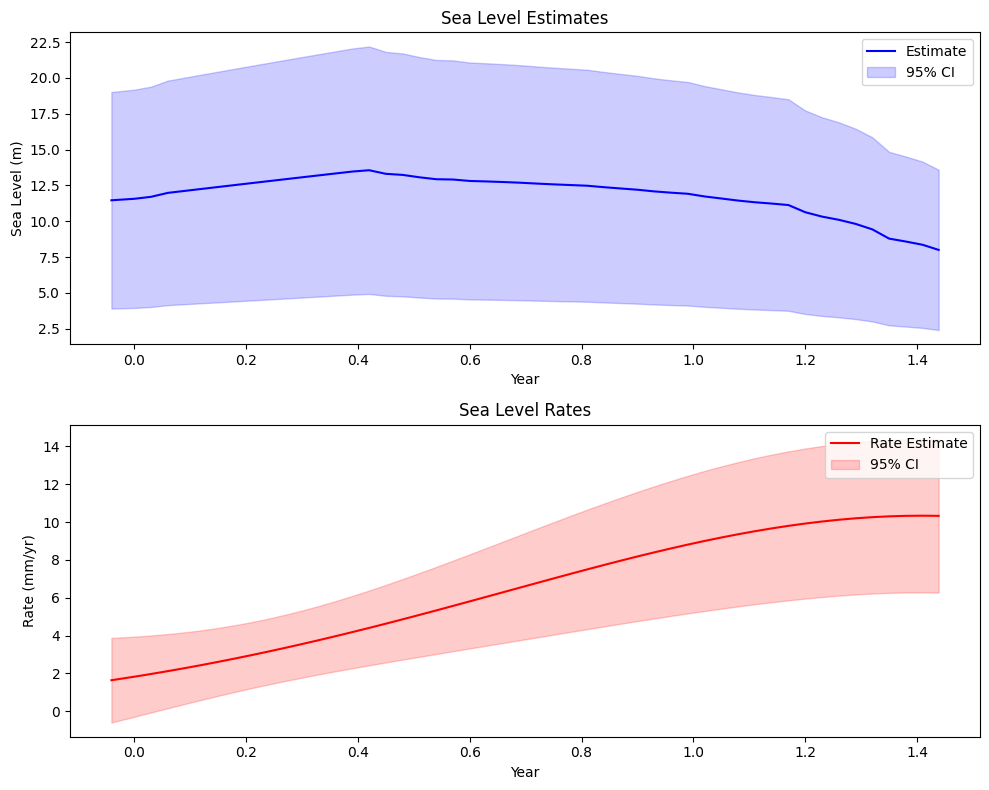

Mean rate: 6.47 mm/yr
95% CI: [4.42, 9.58] mm/yr


In [17]:
# Get predictions
pred = posterior["beta0"][:, None] + np.einsum(
    "ijk,ikl,il->ij", Kgw, Kwinv, posterior["w_m"]
)

# Calculate mean and confidence intervals for predictions
sl_est = np.mean(pred, axis=0)
sl_sd = np.std(pred, axis=0)
sl_lwr = sl_est - 2 * sl_sd
sl_upr = sl_est + 2 * sl_sd

# Calculate mean and confidence intervals for rates
rate_est = np.mean(dydt, axis=0)
rate_sd = np.std(dydt, axis=0)
rate_lwr = rate_est - 2 * rate_sd
rate_upr = rate_est + 2 * rate_sd

# Create plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot SL estimates
ax1.plot(x_star, sl_est, "b-", label="Estimate")
ax1.fill_between(x_star, sl_lwr, sl_upr, color="b", alpha=0.2, label="95% CI")
# ax1.scatter(D[:, 0], D[:, 1], c="k", s=20, alpha=0.5, label="Observations")
# ax1.fill_between(D[:, 0], D[:, 1] - 2 * , y_obs + 2 * sigma_y, color="k", alpha=0.1)
ax1.set_xlabel("Year")
ax1.set_ylabel("Sea Level (m)")
ax1.set_title("Sea Level Estimates")
ax1.legend()

# Plot rates
ax2.plot(x_star, rate_est, "r-", label="Rate Estimate")
ax2.fill_between(x_star, rate_lwr, rate_upr, color="r", alpha=0.2, label="95% CI")
ax2.set_xlabel("Year")
ax2.set_ylabel("Rate (mm/yr)")
ax2.set_title("Sea Level Rates")
ax2.legend()

plt.tight_layout()
plt.show()

# Print mean rate and confidence interval
print(f"Mean rate: {np.mean(mean_dydt):.2f} mm/yr")
print(f"95% CI: [{l95:.2f}, {u95:.2f}] mm/yr")


In [20]:
posterior = mcmc.get_samples()


# SVI


In [48]:
model = eiv_igp
guide = numpyro.infer.autoguide.AutoDiagonalNormal(
    model, init_loc_fn=numpyro.infer.autoguide.init_to_median
)
optimizer = numpyro.optim.Adam(step_size=1e-2)
svi = numpyro.infer.SVI(model, guide, optimizer, loss=numpyro.infer.Trace_ELBO())


svi_result = svi.run(random.PRNGKey(0), 10000)

100%|██████████| 10000/10000 [00:14<00:00, 687.35it/s, init loss: 429643606.8475, avg. loss [9501-10000]: 1025.4017]  


In [49]:
svi_result.params.keys()

dict_keys(['auto_loc', 'auto_scale'])

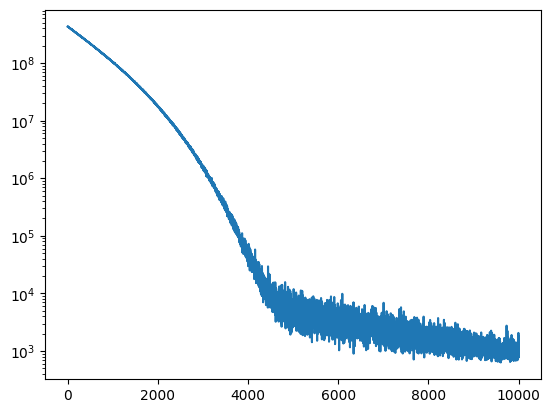

In [50]:
plt.plot(svi_result.losses)
plt.yscale("log")


In [52]:
num_samples = 1000
rng_key = random.PRNGKey(1)
params = guide.sample_posterior(rng_key, svi_result.params, sample_shape=(num_samples,))


(1000, 91)


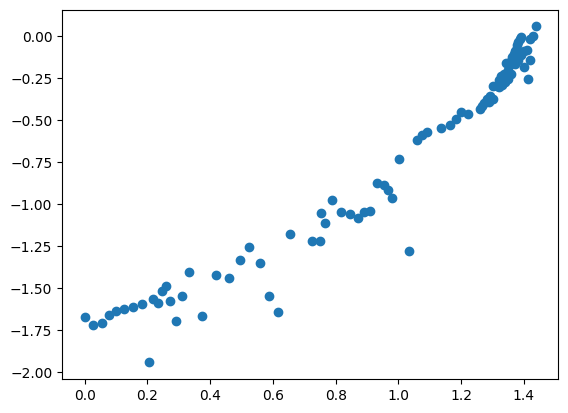

In [58]:
plt.scatter(D[:, 0], D[:, 1])
mu = params["mu"][:, :, 1]
s_idx = np.argsort(D)
print(mu.shape)
# plt.plot(D[:, 0][s_idx], np.mean(mu, axis=0)[s_idx])
